DCGAN (Deep Convolutional GAN): Es una variante del GAN que utiliza capas convolucionales en el generador y el discriminador. Los DCGAN son especialmente efectivos en la generación de imágenes y han demostrado ser más estables que los GAN basados únicamente en capas densas.

Aquitectura 2 mejorando la resolucion de las imagenes a 64x64


In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, Conv2D, LeakyReLU, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Ruta al directorio de imágenes descargadas
directorio_imagenes = "/content/drive/MyDrive/dataset"  # Reemplaza con el directorio correcto

# Lista para almacenar las imágenes y las etiquetas
imagenes = []
etiquetas = []

# Recorre el directorio de imágenes y carga las imágenes en la lista
for nombre_archivo in os.listdir(directorio_imagenes):
    if nombre_archivo.endswith(".jpg"):
        ruta_imagen = os.path.join(directorio_imagenes, nombre_archivo)

        # Verifica si la imagen se puede leer correctamente
        imagen = cv2.imread(ruta_imagen)
        if imagen is None:
            print(f"Error al leer la imagen: {ruta_imagen}")
            continue

        # Verifica si la imagen tiene dimensiones válidas antes de redimensionarla
        if imagen.shape[0] < 64 or imagen.shape[1] < 64:
            print(f"Dimensiones inválidas para la imagen: {ruta_imagen}")
            continue

        imagen = cv2.resize(imagen, (64, 64))  # Redimensiona la imagen a 64x64 píxeles
        imagenes.append(imagen)
        etiquetas.append(1)  # Reemplaza esto con la etiqueta adecuada para cada imagen

# Convierte las listas en matrices numpy
X = np.array(imagenes)
y = np.array(etiquetas)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normaliza los valores de píxeles
trainX = X_train / 255.0
testX = X_test / 255.0

# Ajusta las dimensiones de las matrices de etiquetas
trainy = np.reshape(y_train, (-1, 1))
testy = np.reshape(y_test, (-1, 1))


def define_discriminator(in_shape=(64, 64, 3)):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(512, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # Compilar el modelo
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 256 * 8 * 8
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 256)))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))
    return model


def define_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


# Tamaño del espacio latente
latent_dim = 100

# Crear el discriminador
discriminator = define_discriminator()
discriminator.summary()

# Crear el generador
generator = define_generator(latent_dim)
generator.summary()

# Crear el modelo GAN
gan_model = define_gan(generator, discriminator)
gan_model.summary()

# Resto del código para el entrenamiento


# Entrenamiento

# Configuración de hiperparámetros
n_epochs = 50
n_batch = 64
bat_per_epo = int(trainX.shape[0] / n_batch)

# Carga y preprocesa los datos de entrenamiento utilizando tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((trainX, trainy))
train_dataset = train_dataset.shuffle(buffer_size=trainX.shape[0]).batch(n_batch)

# Bucle de entrenamiento
for epoch in range(n_epochs):
    for batch, (X_real, y_real) in enumerate(train_dataset):
        # Entrenar el discriminador en datos reales
        d_loss1, _ = discriminator.train_on_batch(X_real, y_real)

        # Generar datos falsos
        X_gan = tf.random.normal(shape=(n_batch, latent_dim))
        X_fake = generator.predict(X_gan)
        y_fake = np.zeros((n_batch, 1))

        # Entrenar el discriminador en datos falsos
        d_loss2, _ = discriminator.train_on_batch(X_fake, y_fake)

        # Entrenar el generador
        X_gan = tf.random.normal(shape=(n_batch, latent_dim))
        y_gan = np.ones((n_batch, 1))
        g_loss = gan_model.train_on_batch(X_gan, y_gan)

        # Imprimir progreso
        print(f"Epoch: {epoch+1}/{n_epochs}, Batch: {batch}/{bat_per_epo}, D_loss_real: {d_loss1}, D_loss_fake: {d_loss2}, G_loss: {g_loss}")


Error al leer la imagen: /content/drive/MyDrive/dataset/pothole1.jpg
Error al leer la imagen: /content/drive/MyDrive/dataset/299.jpg
Error al leer la imagen: /content/drive/MyDrive/dataset/478.jpg
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 256)         295168    
                                                       

KeyboardInterrupt: ignored

In [3]:
# Guardar el generador
generator.save('/content/drive/MyDrive/DCGAN_generator_model_2_64x64.h5')

1/1 [==============================] - 0s 472ms/step


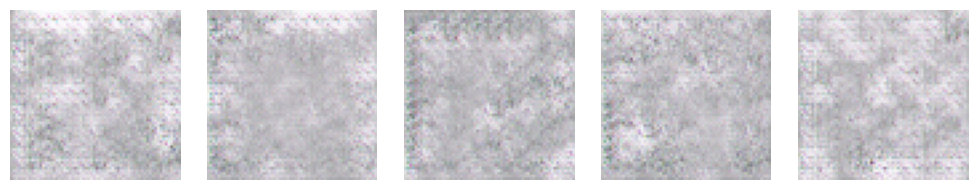

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Cargar el modelo del generador
generator = load_model('/content/drive/MyDrive/DCGAN_generator_model_2_64x64.h5')

# Tamaño del espacio latente
latent_dim = 100

# Generar muestras latentes aleatorias
latent_points = np.random.normal(size=(5, latent_dim))

# Generar imágenes falsas
fake_images = generator.predict(latent_points)
fake_images = (fake_images + 1) / 2.0

# Mostrar las imágenes generadas
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.axis('off')
    ax.imshow(fake_images[i])

plt.tight_layout()
plt.show()